In [35]:
import cv2
import timm
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

import models_vit

plt.rcParams['font.sans-serif']=['SimHei']

In [25]:
label2dia = {
      "0": "未见异常",
      "1": "黄斑前膜",
      "2": "黄斑水肿",
      "3": "DR",
      "4": "干性AMD",
      "5": "湿性AMD",
      "6": "病理性近视"
    }

In [2]:
def reshape_transform(tensor, height=14, width=14):
    '''
    不同参数的Swin网络的height和width是不同的，具体需要查看所对应的配置文件yaml
    height = width = config.DATA.IMG_SIZE / config.MODEL.NUM_HEADS[-1]
    比如该例子中IMG_SIZE: 224  NUM_HEADS: [4, 8, 16, 32]
    height = width = 224 / 32 = 7
    本例patch为14*14,224 / 16 = 14
    '''
    tensor = tensor[:,1:,:]
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [3]:
model = models_vit.__dict__['MM_MIL_vit_large_patch16'](
        num_classes=7,
        drop_path_rate=0.1,
        global_pool=True,
        modality='multi_mil_add'
    )
checkpoint = torch.load('./output/finetune_topcon_BN_MIL_add/checkpoint-best.pth', map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [4]:
model.eval()

MM_MIL_VisionTransformer(
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (OCT_ViT): MIL_VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        

In [13]:
def read_img(img_name):
    # 保证图片输入后为RGB格式，cv2.imread读取后为BGR
    rgb_img = cv2.imread(img_name, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])
    return input_tensor, rgb_img

In [21]:
def read_labels(label_path):
    labels = dict()

    for l in open(label_path).readlines():
        l = json.loads(l)
        name = l['fundus'].split('.')[0]
        labels[name] = l['labels']

    return labels

In [30]:
def get_CAM(img_name, cam):
    fundus_img, rgb_img = read_img('data/images/'+img_name+'.fundus.jpg')
    #OCT_imgs = []
    #for i in range(12):
    #    OCT_imgs.append(read_img('data/images/'+img_name+'_'+str(i+1).zfill(3)+'.jpg'))
    #OCT_imgs = torch.stack(OCT_imgs, 0)
    
    cam.batch_size = 2
    
    outputs = []
    for class_id in range(7):
        class_name = label2dia[str(class_id)]
        grayscale_cam = cam(input_tensor=fundus_img,
                            targets=[ClassifierOutputTarget(class_id)],
                            eigen_smooth=False,
                            aug_smooth=True)

        grayscale_cam = grayscale_cam[0, :]
        output = np.zeros((grayscale_cam.shape[0],grayscale_cam.shape[1]*2, 3))

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        output[:,:grayscale_cam.shape[1],:] = cam_image/255
        output[:,grayscale_cam.shape[1]:,:] = rgb_img      
        outputs.append(output)
    
    return outputs

In [31]:
target_layers = [model.fundus_ViT.blocks[-1].norm2]
cam = GradCAM(model=model.fundus_ViT, target_layers=target_layers,
                  use_cuda=True, reshape_transform=reshape_transform)


KeyboardInterrupt: 

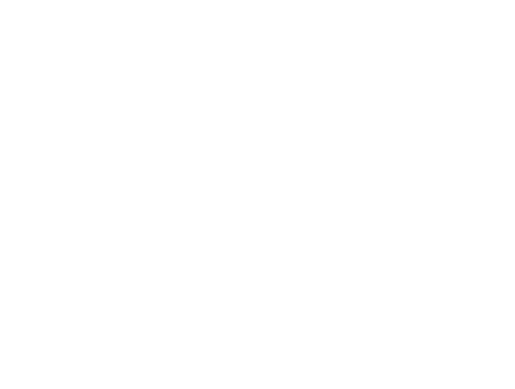

In [55]:
labels = read_labels('data/labels/test')
scores = json.load(open('output/finetune_topcon_BN_MIL_add/scores.json'))
ii = 0
for name in labels.keys():
    outputs = get_CAM(name, cam)
    dir_name = 'data/visualize/'+name
    for l in labels[name]:
        dir_name += ('_'+label2dia[str(l)])
    os.makedirs(dir_name, exist_ok=True)
    for i in range(7):
        plt.axis('off')   # 去坐标轴
        #plt.xticks([])    # 去 x 轴刻度
        #plt.yticks([])    # 去 y 轴刻度
        #plt.imshow(outputs[i])
        #plt.savefig(dir_name+'/'+label2dia[str(i)]+'_'+str(np.round(scores[name][i],4))+'.jpg', dpi=28)
        plt.imsave(dir_name+'/'+label2dia[str(i)]+'_'+str(np.round(scores[name][i],4))+'.jpg', outputs[i])
    


In [28]:
output.shape,output[100:110, 100:110]

((224, 448, 3),
 array([[[0.44705882, 0.24313725, 0.40784314],
         [0.44313725, 0.24313725, 0.41176471],
         [0.44313725, 0.23137255, 0.39607843],
         [0.45490196, 0.23921569, 0.40392157],
         [0.44705882, 0.23921569, 0.4       ],
         [0.44313725, 0.23529412, 0.4       ],
         [0.44705882, 0.23529412, 0.4       ],
         [0.44705882, 0.23529412, 0.4       ],
         [0.45882353, 0.24313725, 0.40392157],
         [0.45098039, 0.23529412, 0.4       ]],
 
        [[0.45098039, 0.23529412, 0.4       ],
         [0.44705882, 0.23529412, 0.40392157],
         [0.44705882, 0.23529412, 0.40784314],
         [0.45098039, 0.24313725, 0.40392157],
         [0.45098039, 0.24705882, 0.40392157],
         [0.45098039, 0.24313725, 0.4       ],
         [0.44705882, 0.23529412, 0.40784314],
         [0.44705882, 0.24313725, 0.4       ],
         [0.44705882, 0.24313725, 0.4       ],
         [0.45098039, 0.23921569, 0.39607843]],
 
        [[0.45882353, 0.23529412, 0.40

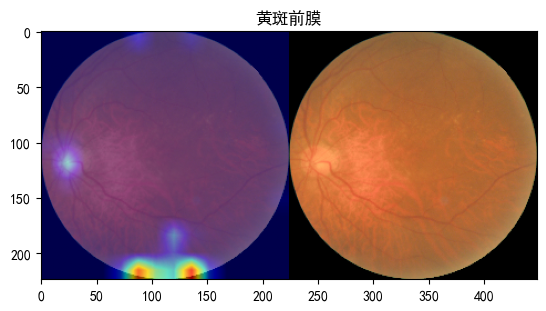

In [20]:
plt.imshow(output)
plt.title('黄斑前膜')
plt.show()

In [24]:

labels

{'20201026_4391': [1],
 '20201026_4390': [3],
 '20201027_4667': [5],
 '20201026_4188': [5],
 '20201027_4962': [2],
 '20201027_4591': [1, 2],
 '20201026_4461': [4],
 '20201027_4860': [4],
 '20201027_4939': [1, 3],
 '20201026_4035': [1],
 '20201026_4271': [1],
 '20201027_5024': [0],
 '20201027_4905': [0],
 '20201027_4904': [0],
 '20201026_4099': [5],
 '20201027_5018': [0],
 '20201027_5017': [0],
 '20201026_4105': [0],
 '20201026_4104': [0],
 '20201026_4049': [0],
 '20201026_4048': [0],
 '20201026_4235': [0],
 '20201026_4237': [0],
 '20201027_4691': [0],
 '20201027_5109': [0],
 '20201027_5076': [0],
 '20201027_4907': [1, 2],
 '20201026_4115': [0],
 '20201026_4171': [0],
 '20201026_4170': [0],
 '20201027_4878': [0],
 '20201027_4879': [0],
 '20201026_4156': [0],
 '20201026_4157': [0],
 '20201027_4525': [0],
 '20201027_4526': [0],
 '20201027_4956': [0],
 '20201027_4957': [0],
 '20201026_4250': [0],
 '20201027_4475': [0],
 '20201027_4649': [0],
 '20201027_4650': [0],
 '20201027_4908': [0],
 '

In [42]:
# 保证图片输入后为RGB格式，cv2.imread读取后为BGR
rgb_img = cv2.imread('data/images/20201027_4837.fundus.jpg', 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                std=[0.5, 0.5, 0.5])

In [51]:
# AblationCAM and ScoreCAM have batched implementations.
# You can override the internal batch size for faster computation.
cam.batch_size = 2

#class_map = {151: "Chihuahua", 281: "tobby cat"}
#class_id = 151
#class_name  = class_map[class_id]
class_id = 1
class_name = '黄斑前膜'
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=[ClassifierOutputTarget(class_id)],
                    eigen_smooth=True,
                    aug_smooth=True)

grayscale_cam.shape

(1, 224, 224)

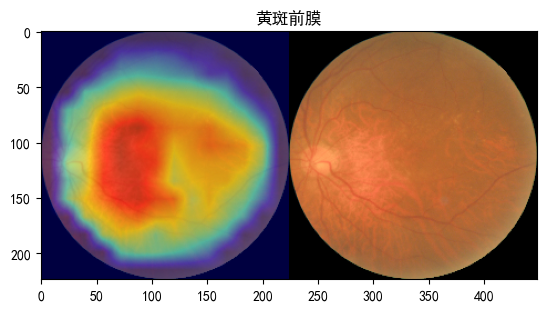

In [52]:
grayscale_cam = grayscale_cam[0, :]
output = np.zeros((grayscale_cam.shape[0],grayscale_cam.shape[1]*2, 3))

cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
output[:,:grayscale_cam.shape[1],:] = cam_image/255
output[:,grayscale_cam.shape[1]:,:] = rgb_img        
                  
plt.imshow(output)
plt.title(class_name)
plt.show()

In [5]:
import torch
a = torch.tensor(
    [[[1., 1., 1., 1.],
      [1., 1., 1., 1.],
      [1., 1., 1., 1.]],
 
     [[1., 1., 1., 1.],
      [1., 12., 1., 1.],
      [1., 1., 1., 1.]]]
)
b = torch.tensor(
    [[[1., 1., 1., 3.]],
 
     [[1., 1., 1., 1.]]]
)
c = a*b
c, c.shape

(tensor([[[ 1.,  1.,  1.,  3.],
          [ 1.,  1.,  1.,  3.],
          [ 1.,  1.,  1.,  3.]],
 
         [[ 1.,  1.,  1.,  1.],
          [ 1., 12.,  1.,  1.],
          [ 1.,  1.,  1.,  1.]]]),
 torch.Size([2, 3, 4]))

In [7]:
d = torch.sum(c, dim = 1)
d, d.shape

(tensor([[ 3.,  3.,  3.,  9.],
         [ 3., 14.,  3.,  3.]]),
 torch.Size([2, 4]))